In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.io import fits
import h5py
from astropy.table import Table
from batman import TransitParams, TransitModel
from astropy.stats import mad_std
from astropy.constants import R_earth, R_sun
from astropy.time import Time
import sys
sys.path.insert(0, '../../../TESSellate/')
from toolkit import LightCurve
from astropy.time import Time

from keras.models import load_model

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [5]:
model = load_model('../data/model.hdf5')

In [6]:
import pandas as pd

tois = pd.read_csv('../../../TESSellate/exofop_tess_tois.csv', skiprows=1)

In [7]:
from astropy.stats import sigma_clip

In [8]:
conditions = (tois['TESS mag'] < 12) & (tois['Stellar Teff (K)'] < 6000) & (tois['Depth (mmag)'] > 0.5)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


281459670 [False False False False  True False False False False False False False
 False False False False]


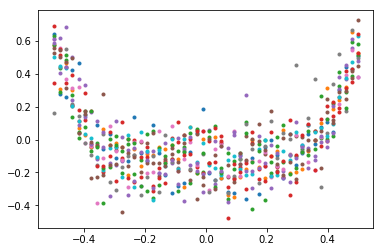

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encountered


260985861 [False  True  True  True False  True  True]


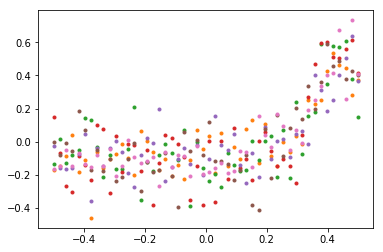

149990841 [False False False False False False False  True  True False  True False]


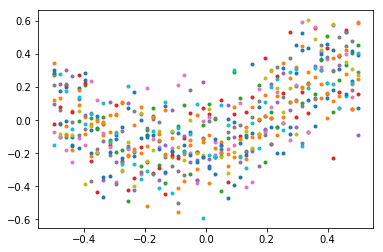

../../../TESSellate/toolkit/lightcurve.py:303: RuntimeWarning: invalid value encountered in less
  near_transit = ((phased < params.duration*(0.5 + oot_duration_fraction)) |
../../../TESSellate/toolkit/lightcurve.py:304: RuntimeWarning: invalid value encountered in greater
  (phased > params.per - params.duration*(0.5 + oot_duration_fraction)))


55652896 [ True False  True False False  True  True]


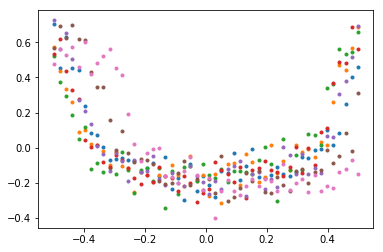

55652896 [ True False  True False False  True  True]


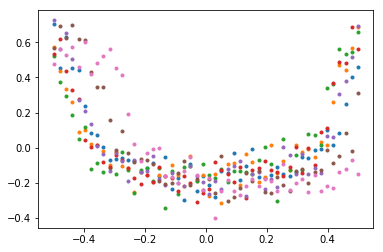

382626661 [False False False False  True False False False False False False False
 False False False False]


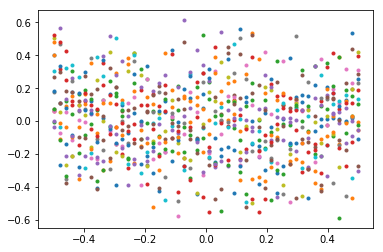

9033144 [False  True False False  True  True]


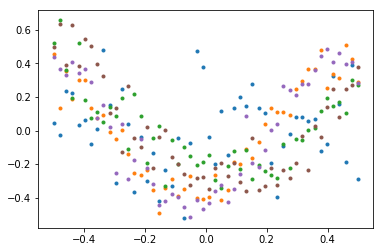

../../../TESSellate/toolkit/lightcurve.py:603: RankWarning: Polyfit may be poorly conditioned
  self.fluxes[mask][~near_transit], order)
../../../TESSellate/toolkit/lightcurve.py:603: RankWarning: Polyfit may be poorly conditioned
  self.fluxes[mask][~near_transit], order)


306362738 [False False False  True False False False]


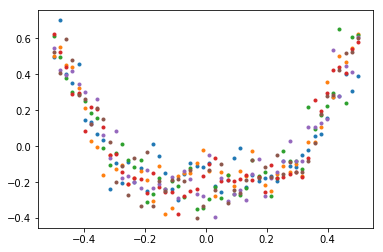

134537478 [False  True False False False False False False False False False False
 False False]


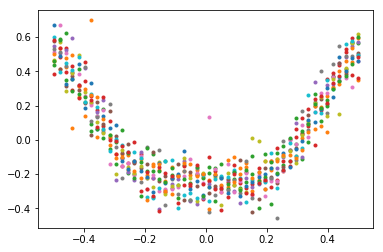

349790953 [False  True False  True  True  True False False False False  True False
  True False False False False  True  True  True False  True False False
  True False  True False  True  True False  True  True False False False
 False False  True False  True False  True False  True False False False
 False False False False  True False False False False  True False False
 False False  True False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False  True False False False
 False False  True False  True False False  True False  True  True  True
  True False False]


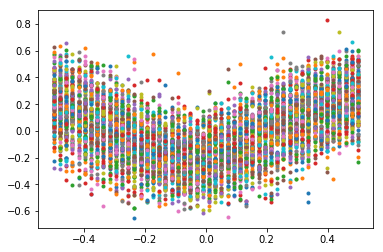

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


55383975 [False False False False  True]


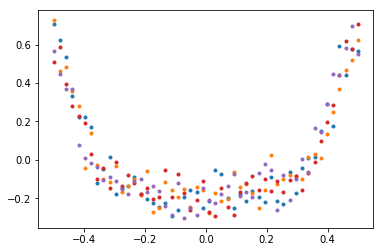

150247134 [ True False False False False False False False False False]


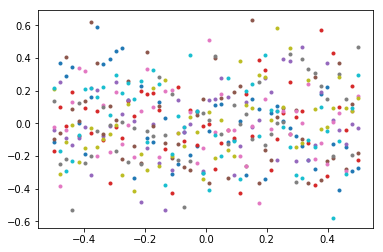

398943781 [False  True False False False False False]


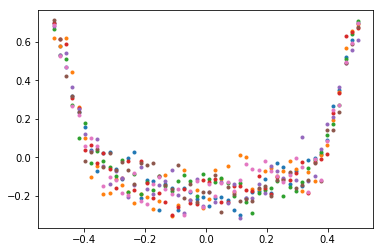

307610438 [ True False False False False False False False False False False False
 False False]


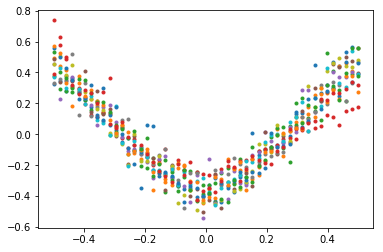

In [28]:
from scipy.stats import binned_statistic
import os

bin_times = np.linspace(-0.5, 0.5, 51)
interp_times = np.linspace(-0.5, 0.5, 50)

tois_searched = []
tois_spotted = []

for ticid in tois[conditions]['TIC ID'].values:
    path = '../../../TESSellate/downloads/{0}.npy'.format(ticid)
    if os.path.exists(path):
        times, fluxes = np.load(path).T
        not_nan = ~np.isnan(times) & ~np.isnan(fluxes)

        toi_props = tois[tois['TIC ID'] == int(ticid)]

        epoch, period, duration = toi_props["Epoch (BJD)"].values[0], toi_props["Period (days)"].values[0], toi_props["Duration (hours)"].values[0] / 24

        lc = LightCurve(Time(times[not_nan] + 2457000, format='jd'), fluxes[not_nan])

        params = TransitParams()
        params.t0 = epoch
        params.per = period
        params.duration = duration

        transits = lc.mask_out_of_transit(params, oot_duration_fraction=1)
        if len(transits['times']) > 0:
            transits = LightCurve(**transits).get_transit_light_curves(params)

            resampled_transits = []
            for transit in transits: 

                transit.remove_polynomial_baseline(params)
        #         transit.plot(ax=ax, plot_kwargs={'lw': 0, 'marker': '.', 'color': 'b'})
        #         plt.show()

                midtransittime = round((transit.times.jd.mean() - params.t0) / params.per)

                interped_lc = binned_statistic((transit.times.jd - (params.t0 + midtransittime*params.per)) / duration, 
                                                transit.fluxes, bins=bin_times, statistic='median').statistic
                interped_lc -= np.nanmean(interped_lc)
                interped_lc /= (np.nanmax(interped_lc) - np.nanmin(interped_lc))

                interped_lc /= interped_lc.ptp()
                resampled_transits.append(interped_lc)

            if len(resampled_transits) > 0:
                resampled_transits = np.vstack(resampled_transits)
                pred_y = model.predict(resampled_transits[:, :, np.newaxis], batch_size = 128)
                bools = pred_y[:, 1] > 0.99
                ten_percent_spotted = np.count_nonzero(bools)/len(bools) >= 0.05
                
                if ten_percent_spotted: 
                    print(ticid, bools)
                    plt.plot(interp_times, resampled_transits.T, '.')
                    plt.show()
                tois_searched.append(ticid)
                tois_spotted.append(ten_percent_spotted)
                
#                     resampled_transits = np.vstack(resampled_transits)[:, :, np.newaxis]

#                     pred_y = model.predict(resampled_transits, batch_size = 128)
                    
#                     # (nor really but sort of) assignment probability spotted >99%
#                     bools = pred_y[:, 1] > 0.99 #np.argmax(pred_y, axis=1).astype(bool)
#                     kepids.append(kepid)
#                     # If there are at least 10 flagged transits, flag the object: 
#                     if np.count_nonzero(bools) > 10: 
#                         print(kepid, props['kepler_name'])
# #                         print(bools)
#                         plt.figure(figsize=(4,3))
#                         plt.plot(np.linspace(-0.5, 0.5, 50), resampled_transits[bools, :, 0].T, 'r.', alpha=0.05, rasterized=True)
#                         plt.plot(np.linspace(-0.5, 0.5, 50), resampled_transits[np.logical_not(bools), :, 0].T, '.k', alpha=0.01, rasterized=True)
#                         plt.xlabel('Time [duration]')
#                         plt.ylabel('Normalized Flux')
#                         plt.ylim([-0.4, 0.8])
#                         plt.savefig('plots/{0}.pdf'.format(kepid), bbox_inches='tight')
#                         plt.show()
#                         if kepid == '007051180': 
#                             np.save('data/007051180.npy', bools)
#                     else: 
#                         print('skipped', props['kepler_name'])

In [29]:
len(tois_searched)

268

398943781 721    780.01
Name: TOI, dtype: float64


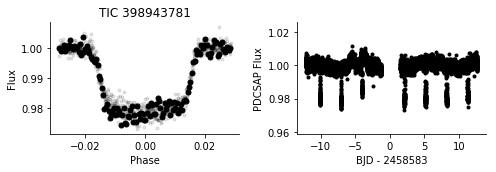

306362738 401    479.01
Name: TOI, dtype: float64


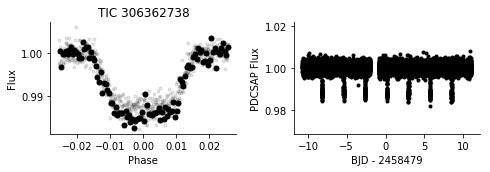

In [57]:
closer_look = [398943781, 306362738]
bools = [[False,  True, False, False, False, False, False],
         [False, False, False,  True, False, False, False]]
for ticid, booleans in zip(closer_look, bools):
    path = '../../../TESSellate/downloads/{0}.npy'.format(ticid)
    if os.path.exists(path):
        times, fluxes = np.load(path).T
        not_nan = ~np.isnan(times) & ~np.isnan(fluxes)

        toi_props = tois[tois['TIC ID'] == int(ticid)]

        epoch, period, duration = toi_props["Epoch (BJD)"].values[0], toi_props["Period (days)"].values[0], toi_props["Duration (hours)"].values[0] / 24

        lc = LightCurve(Time(times[not_nan] + 2457000, format='jd'), fluxes[not_nan])

        params = TransitParams()
        params.t0 = epoch
        params.per = period
        params.duration = duration
        fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
        jdint = int(lc.times.jd.mean())
        ax[1].scatter(lc.times.jd - jdint, lc.fluxes/np.median(lc.fluxes), marker='.', color='k', rasterized=True)
        ax[1].set_xlabel('BJD - {0}'.format(jdint))
        ax[1].set_ylabel('PDCSAP Flux')
        transits = lc.mask_out_of_transit(params, oot_duration_fraction=0.3)
        if len(transits['times']) > 0:
            transits = LightCurve(**transits).get_transit_light_curves(params)

            resampled_transits = []
            for transit, b in zip(transits, booleans): 
                transit.remove_polynomial_baseline(params)

                if b: 
                    transit.plot(params, phase=True, show=False, ax=ax[0], 
                                 plot_kwargs=dict(lw=0, marker='o', color='k', ms=5))
                else: 
                    transit.plot(params, phase=True, show=False, ax=ax[0],
                                 plot_kwargs=dict(alpha=0.1, lw=0, marker='.', color='k', zorder=-10))


        ax[0].set_title('TIC {0}'.format(ticid))
        print(ticid, toi_props['TOI'])
        
        for s in ['right', 'top']: 
            for axis in ax: 
                axis.spines[s].set_visible(False)
        
        fig.tight_layout()
        fig.savefig('plots/tic{0}.pdf'.format(ticid), bbox_inches='tight', dpi=250)
        plt.show()

In [53]:
toi_props

,TIC ID,TOI,Previous CTOI,Master priority,SG1A priority,SG1B priority,SG2 priority,SG3 priority,SG4 priority,SG5 priority,...,Stellar Teff (K),Stellar Teff error,Stellar log(g) (cm/s2),Stellar log(g) error,Stellar Radius (R_Sun),Stellar Radius error,Sectors,Comments,Date Created,Date Modified
401,306362738,479.01,NaN,5,5,5,5,4,5,5,...,5706.0,188.0,4.45234,0.377432,0.99232,0.177265,6,WASP-49,2019-02-22,2019-06-17
